In [1]:
from datetime import datetime, timedelta
import time
from collections import namedtuple
import pandas as pd
import requests
import matplotlib.pyplot as plt

In [2]:
API_KEY = '9b47f685a716d06d'
BASE_URL = 'http://api.wunderground.com/api/{}/history_{}/q/NE/Lincoln.json'

In [3]:
target_date = datetime(2016, 5, 16)
features = ["date", "meantempm", "meandewptm", "meanpressurem", "maxhumidity", "minhumidity", "maxtempm",
           "mintempm", "maxdewptm", "mindewptm", "maxpressurem", "minpressurem", "precipm"]
DailySummary = namedtuple('DailySummary', features)

In [4]:
def extract_weather_data(url, api_key, target_date, days):  
    records = []
    for _ in range(days):
        request = BASE_URL.format(API_KEY, target_date.strftime('%Y%m%d'))
        response = requests.get(request)
        if response.status_code == 200:
            data = response.json()['history']['dailysummary'][0]
            records.append(DailySummary(
                date=target_date,
                meantempm=data['meantempm'],
                meandewptm=data['meandewptm'],
                meanpressurem=data['meanpressurem'],
                maxhumidity=data['maxhumidity'],
                minhumidity=data['minhumidity'],
                maxtempm=data['maxtempm'],
                mintempm=data['mintempm'],
                maxdewptm=data['maxdewptm'],
                mindewptm=data['mindewptm'],
                maxpressurem=data['maxpressurem'],
                minpressurem=data['minpressurem'],
                precipm=data['precipm']))
        time.sleep(6)
        target_date += timedelta(days=1)
    return records

In [5]:
records = extract_weather_data(BASE_URL, API_KEY, target_date, 500)

In [8]:
records += extract_weather_data(BASE_URL, API_KEY, target_date, 500)

In [9]:
df = pd.DataFrame(records, columns=features).set_index('date')

In [10]:
tmp = df[['meantempm', 'meandewptm']].head(10)
tmp

,meantempm,meandewptm
date,,
2016-05-16,11,8
2016-05-17,14,8
2016-05-18,14,6
2016-05-19,16,8
2016-05-20,15,11
2016-05-21,18,9
2016-05-22,22,14
2016-05-23,21,17
2016-05-24,22,16


In [11]:
# 1 day prior
N = 1

# target measurement of mean temperature
feature = 'meantempm'

# total number of rows
rows = tmp.shape[0]

# a list representing Nth prior measurements of feature
# notice that the front of the list needs to be padded with N
# None values to maintain the consistent rows length for each N
nth_prior_measurements = [None]*N + [tmp[feature][i-N] for i in range(N, rows)]

# makee a new column name of feature_N and add to DataFrame
col_name = '{}_{}'.format(feature, N)
tmp[col_name] = nth_prior_measurements
tmp

,meantempm,meandewptm,meantempm_1
date,,,
2016-05-16,11,8,None
2016-05-17,14,8,11
2016-05-18,14,6,14
2016-05-19,16,8,14
2016-05-20,15,11,16
2016-05-21,18,9,15
2016-05-22,22,14,18
2016-05-23,21,17,22
2016-05-24,22,16,21


In [12]:
def derive_nth_day_feature(df, feature, N):
    rows = df.shape[0]
    nth_prior_measurements = [None]*N + [df[feature][i-N] for i in range(N, rows)]
    col_name = '{}_{}'.format(feature, N)
    df[col_name] = nth_prior_measurements

In [13]:
for feature in features:
    if feature != 'date':
        for N in range(1, 4):
            derive_nth_day_feature(df, feature, N)

In [14]:
df.columns

Index(['meantempm', 'meandewptm', 'meanpressurem', 'maxhumidity',
       'minhumidity', 'maxtempm', 'mintempm', 'maxdewptm', 'mindewptm',
       'maxpressurem', 'minpressurem', 'precipm', 'meantempm_1', 'meantempm_2',
       'meantempm_3', 'meandewptm_1', 'meandewptm_2', 'meandewptm_3',
       'meanpressurem_1', 'meanpressurem_2', 'meanpressurem_3',
       'maxhumidity_1', 'maxhumidity_2', 'maxhumidity_3', 'minhumidity_1',
       'minhumidity_2', 'minhumidity_3', 'maxtempm_1', 'maxtempm_2',
       'maxtempm_3', 'mintempm_1', 'mintempm_2', 'mintempm_3', 'maxdewptm_1',
       'maxdewptm_2', 'maxdewptm_3', 'mindewptm_1', 'mindewptm_2',
       'mindewptm_3', 'maxpressurem_1', 'maxpressurem_2', 'maxpressurem_3',
       'minpressurem_1', 'minpressurem_2', 'minpressurem_3', 'precipm_1',
       'precipm_2', 'precipm_3'],
      dtype='object')

In [15]:
# make list of original features without meantempm, mintempm, and maxtempm
to_remove = [feature
             for feature in features
             if feature not in ['meantempm', 'mintempm', 'maxtempm']]

# make a list of columns to keep
to_keep = [col for col in df.columns if col not in to_remove]

# select only the columns in to_keep and assign to df
df = df[to_keep]
df.columns

Index(['meantempm', 'maxtempm', 'mintempm', 'meantempm_1', 'meantempm_2',
       'meantempm_3', 'meandewptm_1', 'meandewptm_2', 'meandewptm_3',
       'meanpressurem_1', 'meanpressurem_2', 'meanpressurem_3',
       'maxhumidity_1', 'maxhumidity_2', 'maxhumidity_3', 'minhumidity_1',
       'minhumidity_2', 'minhumidity_3', 'maxtempm_1', 'maxtempm_2',
       'maxtempm_3', 'mintempm_1', 'mintempm_2', 'mintempm_3', 'maxdewptm_1',
       'maxdewptm_2', 'maxdewptm_3', 'mindewptm_1', 'mindewptm_2',
       'mindewptm_3', 'maxpressurem_1', 'maxpressurem_2', 'maxpressurem_3',
       'minpressurem_1', 'minpressurem_2', 'minpressurem_3', 'precipm_1',
       'precipm_2', 'precipm_3'],
      dtype='object')

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1000 entries, 2016-05-16 to 2017-09-27
Data columns (total 39 columns):
meantempm          1000 non-null object
maxtempm           1000 non-null object
mintempm           1000 non-null object
meantempm_1        999 non-null object
meantempm_2        998 non-null object
meantempm_3        997 non-null object
meandewptm_1       999 non-null object
meandewptm_2       998 non-null object
meandewptm_3       997 non-null object
meanpressurem_1    999 non-null object
meanpressurem_2    998 non-null object
meanpressurem_3    997 non-null object
maxhumidity_1      999 non-null object
maxhumidity_2      998 non-null object
maxhumidity_3      997 non-null object
minhumidity_1      999 non-null object
minhumidity_2      998 non-null object
minhumidity_3      997 non-null object
maxtempm_1         999 non-null object
maxtempm_2         998 non-null object
maxtempm_3         997 non-null object
mintempm_1         999 non-null object
mintempm_2    

In [17]:
df = df.apply(pd.to_numeric, errors='coerce')
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1000 entries, 2016-05-16 to 2017-09-27
Data columns (total 39 columns):
meantempm          1000 non-null int64
maxtempm           1000 non-null int64
mintempm           1000 non-null int64
meantempm_1        999 non-null float64
meantempm_2        998 non-null float64
meantempm_3        997 non-null float64
meandewptm_1       999 non-null float64
meandewptm_2       998 non-null float64
meandewptm_3       997 non-null float64
meanpressurem_1    999 non-null float64
meanpressurem_2    998 non-null float64
meanpressurem_3    997 non-null float64
maxhumidity_1      999 non-null float64
maxhumidity_2      998 non-null float64
maxhumidity_3      997 non-null float64
minhumidity_1      999 non-null float64
minhumidity_2      998 non-null float64
minhumidity_3      997 non-null float64
maxtempm_1         999 non-null float64
maxtempm_2         998 non-null float64
maxtempm_3         997 non-null float64
mintempm_1         999 non-null float6

In [18]:
# Call describe on df and transpose it due to the large number of columns
spread = df.describe().T

# precalculate interquartile range for ease of use in next calculation
IQR = spread['75%'] - spread['25%']

# create an outliers column which is either 3 IQRs below the first quartile or
# 3 IQRs above the third quartile
spread['outliers'] = (spread['min']<(spread['25%']-(3*IQR)))|(spread['max'] > (spread['75%']+3*IQR))

# just display the features containing extreame outliers
spread.ix[spread.outliers,]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if sys.path[0] == '':


,count,mean,std,min,25%,50%,75%,max,outliers
maxhumidity_1,999.0,88.939940,8.679808,53.0,84.0,91.0,93.00,100.00,True
maxhumidity_2,998.0,88.935872,8.683207,53.0,84.0,91.0,93.00,100.00,True
maxhumidity_3,997.0,88.927783,8.683803,53.0,84.0,91.0,93.00,100.00,True
precipm_1,895.0,2.928179,9.068300,0.0,0.0,0.0,0.25,94.49,True
precipm_2,895.0,2.928179,9.068300,0.0,0.0,0.0,0.25,94.49,True
precipm_3,894.0,2.909004,9.055205,0.0,0.0,0.0,0.25,94.49,True


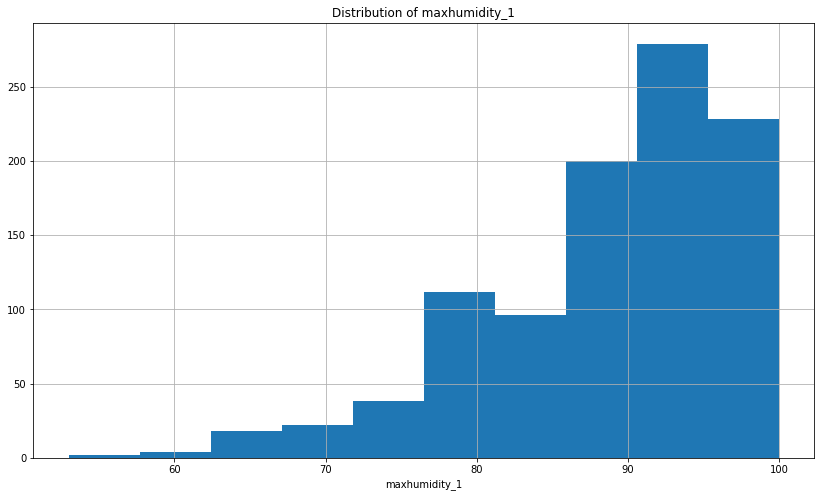

In [19]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [14, 8]
df.maxhumidity_1.hist()
plt.title('Distribution of maxhumidity_1')
plt.xlabel('maxhumidity_1')
plt.show()

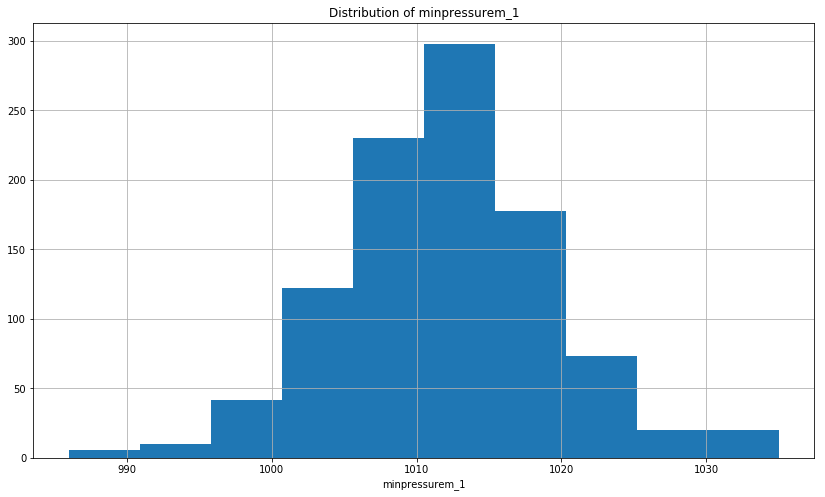

In [21]:
df.minpressurem_1.hist()
plt.title('Distribution of minpressurem_1')
plt.xlabel('minpressurem_1')
plt.show()

In [23]:
# iterate over the precip columns
for precip_col in ['precipm_1', 'precipm_2', 'precipm_3']:
    # create a boolean array of values representing nans
    missing_vals = pd.isnull(df[precip_col])
    df[precip_col][missing_vals] = 0

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [24]:
df = df.dropna()

In [25]:
import pickle
with open('end-part1_df.pkl', 'wb') as f:
    pickle.dump(df, f)